# Регрессия
### Набор данных взят [отсюда](https://www.kaggle.com/datasets/aleksandrglotov/car-prices-poland)

В данном наборе изначально дано 11 столбцов и 118.000 строк с данными для каждой фичи

Цель регрессии - предсказать цену на машину в Польше

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Затрачено времени: %i часов %i минут и %s секунд.' % (thour, tmin, round(tsec, 2)))

## Считываем данные из файла для тренировки модели

In [3]:
df = pd.read_csv("./data/Car_Prices_Poland_Kaggle.csv")

# Предварительная обработка данных
## Проверка типов данных
Смотрим информацию о датасете, сколько записей содержится и какие типы данных у строк

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


Здесь:

- mark - марка автомобиля

- model - его модель

- generation_name - название поколения

- year - год выпуска

- mileage - пробег в км

- vol_engine - объем двигателя

- fuel - используемое топливо

- city - город продажи

- province - регион Польши

- price - цена за автомобиль

Сразу можно заметить, что от некоторых полей можно избавиться:

- generation_name не актуален, т.к. есть год выпуска

- регион Польши не нужен, т.к. мы уже знаем город продажи

In [5]:
df.drop(["generation_name"], axis=1, inplace=True)
df.drop(["province"], axis=1, inplace=True)

## Убираем строки с теми данными, которые не заполнены
Сначала посмотрим, сколько таких строк у нас всего

In [6]:
df.isnull().sum()

Unnamed: 0    0
mark          0
model         0
year          0
mileage       0
vol_engine    0
fuel          0
city          0
price         0
dtype: int64

Пропусков нет :)

Уберем дупликаты, если такие есть, и посмотрим итоговое значение строк, которые у нас остаются

In [7]:
df = df.drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117927 entries, 0 to 117926
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  117927 non-null  int64 
 1   mark        117927 non-null  object
 2   model       117927 non-null  object
 3   year        117927 non-null  int64 
 4   mileage     117927 non-null  int64 
 5   vol_engine  117927 non-null  int64 
 6   fuel        117927 non-null  object
 7   city        117927 non-null  object
 8   price       117927 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 9.0+ MB


Как можно заметить, дупликатов тут тоже нет, значит продолжаем работу.

Посмотрим, какие данные у нас имеются по каждой из фичей

<AxesSubplot: xlabel='count', ylabel='mark'>

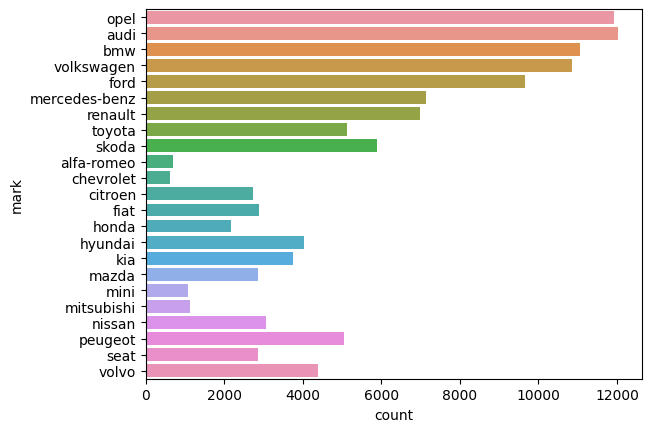

In [8]:
sns.countplot(y=df["mark"])

Марки машин плюс-минус распределены хорошо, **оставим как есть**

<AxesSubplot: xlabel='model', ylabel='count'>

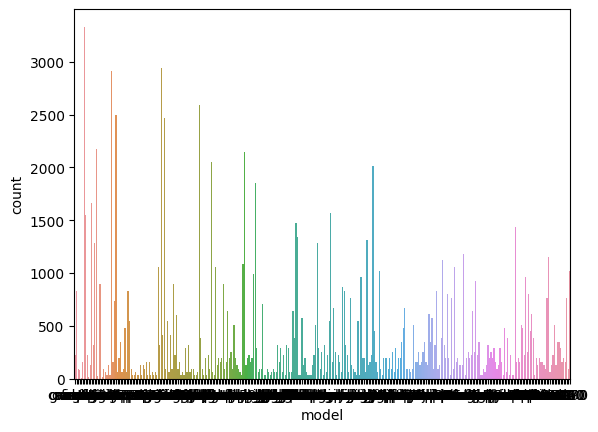

In [9]:
sns.countplot(x=df["model"])

<AxesSubplot: xlabel='count', ylabel='year'>

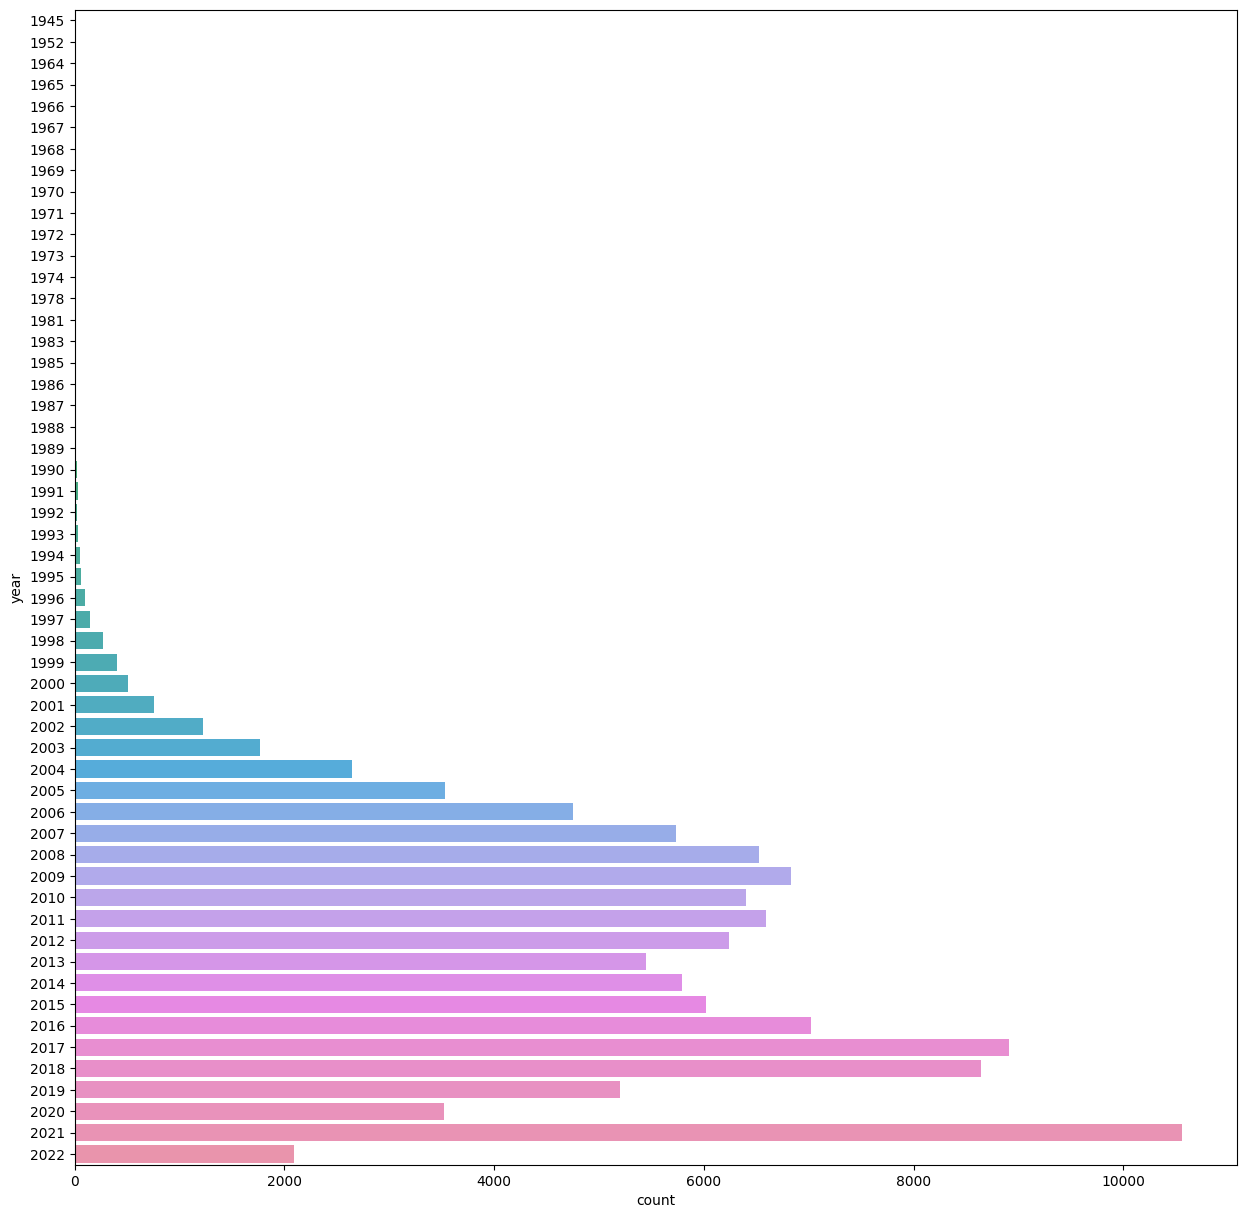

In [10]:
plt.figure(figsize=(15, 15))
sns.countplot(y=df["year"])

Отберем из этих годов наш век:

<AxesSubplot: xlabel='count', ylabel='year'>

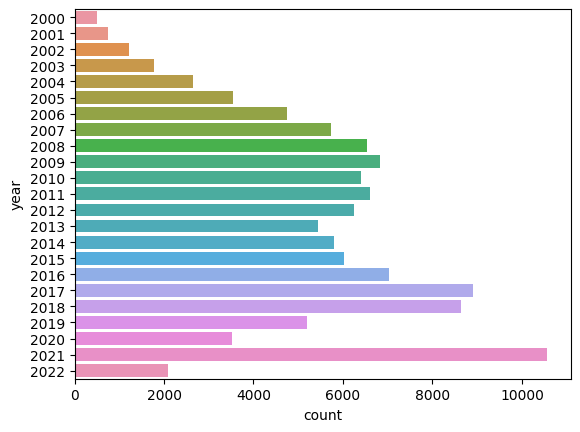

In [11]:
df = df.query("year >= 2000")
sns.countplot(y=df["year"])

array([[<AxesSubplot: title={'center': 'mileage'}>]], dtype=object)

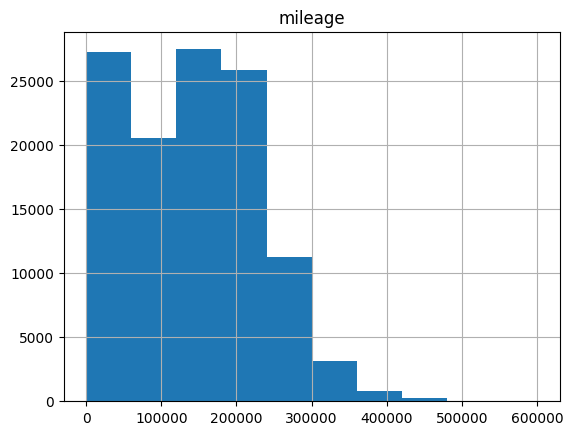

In [12]:
df.hist(column='mileage', range=[0,600000])

array([[<AxesSubplot: title={'center': 'vol_engine'}>]], dtype=object)

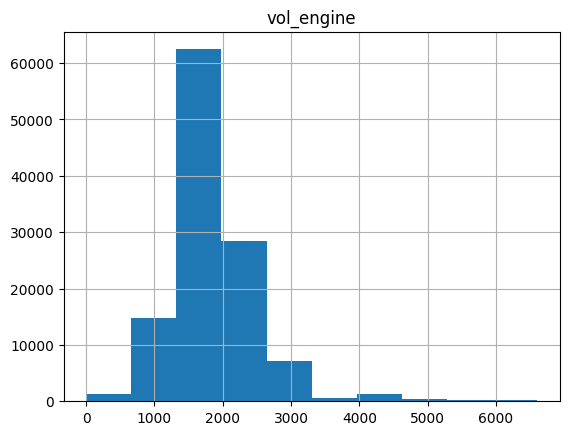

In [13]:
#sns.countplot(x=df["vol_engine"])
df.hist(column='vol_engine')

Gasoline    60794
Diesel      48295
LPG          4080
Hybrid       2621
Electric      885
CNG            47
Name: fuel, dtype: int64

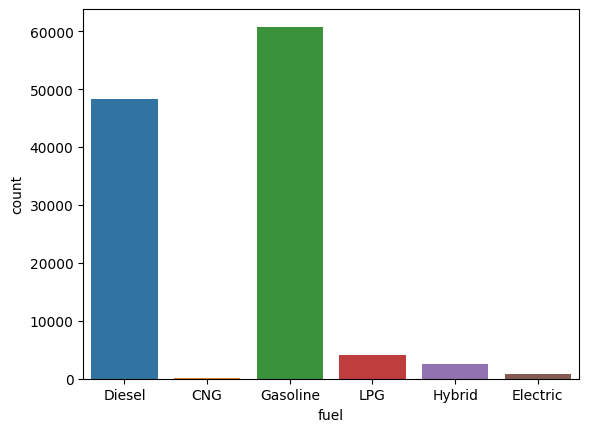

In [14]:
sns.countplot(x=df["fuel"])
df["fuel"].value_counts()

В основном привелируют бензиновые и дизельные двигатели, их мы и оставим.

<AxesSubplot: xlabel='fuel', ylabel='count'>

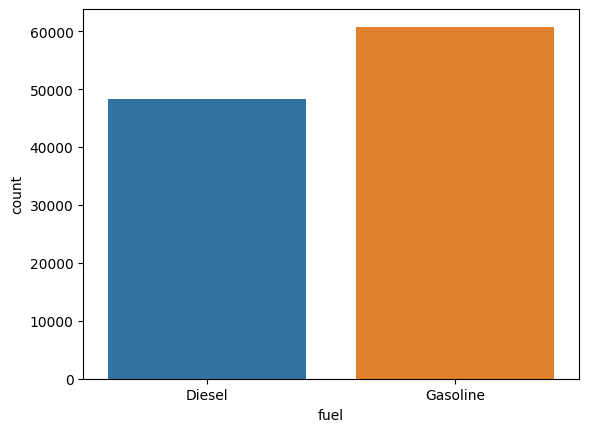

In [15]:
df = df.query("fuel == 'Gasoline' or fuel == 'Diesel'")
sns.countplot(x=df["fuel"])

In [16]:
#sns.countplot(x=df["city"])
df['city'].value_counts()

Warszawa    7300
Łódź        2998
Kraków      2629
Wrocław     2497
Poznań      2163
            ... 
Kalwy          1
Szymonki       1
Głosków        1
Prusy          1
Bledzew        1
Name: city, Length: 4208, dtype: int64

Как можно заметить, есть города, где продаж ну очень мало. Отфильтруем те, где продаж было не менее 100 хотя бы

In [17]:
counts = df['city'].value_counts()

df = df[~df['city'].isin(counts[counts < 100].index)]
df['city'].value_counts()

Warszawa              7300
Łódź                  2998
Kraków                2629
Wrocław               2497
Poznań                2163
                      ... 
Góra Kalwaria          102
Kowale                 101
Środa Wielkopolska     101
Gostyń                 100
Tarnobrzeg             100
Name: city, Length: 184, dtype: int64

Теперь другое дело :)

Посмотрим, сколько у нас осталось данных

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77062 entries, 0 to 117925
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  77062 non-null  int64 
 1   mark        77062 non-null  object
 2   model       77062 non-null  object
 3   year        77062 non-null  int64 
 4   mileage     77062 non-null  int64 
 5   vol_engine  77062 non-null  int64 
 6   fuel        77062 non-null  object
 7   city        77062 non-null  object
 8   price       77062 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 5.9+ MB


Последние штрихи и приступим к регрессии

In [19]:
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1 - бензин, 0 - дизель
df['fuel'].replace(['Diesel'], 0, inplace=True)
df['fuel'].replace(['Gasoline'], 1, inplace=True)

# Город - столбец. 1, если продавали там

df_nums = df.copy()

cat_columns_dummies = ["mark", "model", "city"]

for col_i in cat_columns_dummies:
    #df_nums[col_i] = df_nums[col_i].astype('category')
    #df_nums[col_i] = df_nums[col_i].cat.codes
    #df_nums[col_i] = df_nums[col_i].astype(int)
    temp = pd.get_dummies(df_nums[col_i])
    df_nums = pd.concat([df_nums, temp], axis = 1)
    df_nums.drop([col_i], axis = 1, inplace = True) # inplace=False is copy, inplace=True is not copy

df_nums.dtypes

year          int64
mileage       int64
vol_engine    int64
fuel          int64
price         int64
              ...  
Żary          uint8
Żory          uint8
Żuromin       uint8
Żyrardów      uint8
Żywocice      uint8
Length: 529, dtype: object

In [20]:
df_nums

,year,mileage,vol_engine,fuel,price,alfa-romeo,audi,bmw,chevrolet,citroen,...,Środa Wielkopolska,Środa Śląska,Świdnica,Świdnik,Świebodzin,Żary,Żory,Żuromin,Żyrardów,Żywocice
0,2015,139568,1248,0,35900,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018,31991,1499,0,78501,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2017,121203,1598,0,51900,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2017,119965,1248,0,44700,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2016,201658,1248,0,29000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,2018,108237,1969,0,234900,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117917,2016,131000,1969,0,177798,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117920,2018,53500,1969,1,159500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117924,2016,83500,1969,1,135000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Цель - цена

39900     774
19900     768
29900     717
18900     655
49900     649
         ... 
148030      1
120990      1
119920      1
96490       1
215600      1
Name: price, Length: 7793, dtype: int64

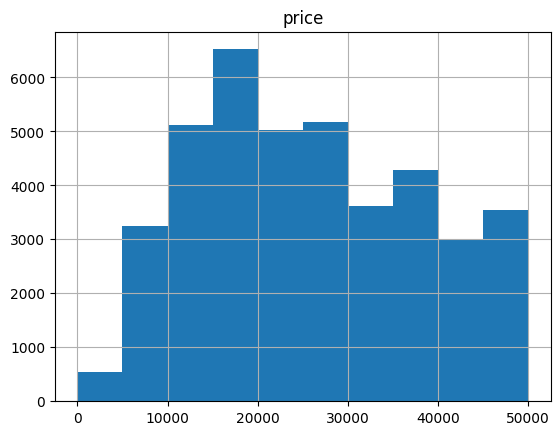

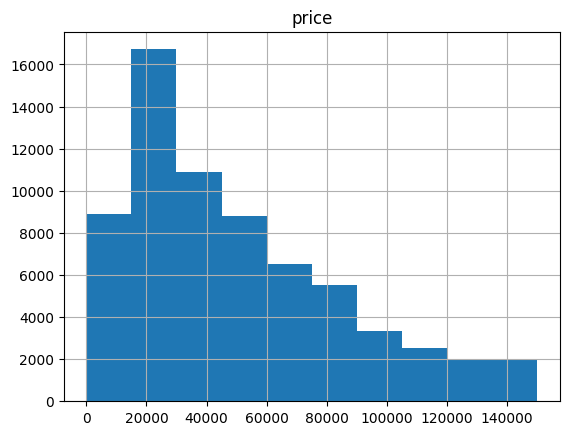

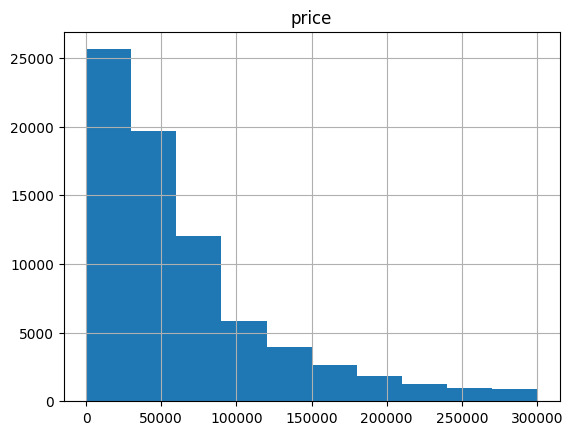

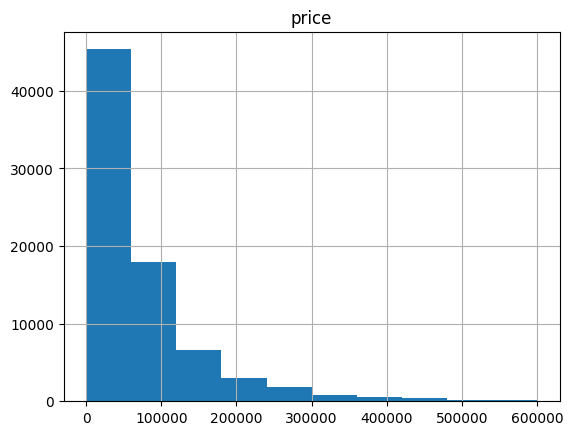

In [21]:
for end in [50000, 150000, 300000, 600000]:
    df_nums.hist(column='price', range=[0,end])
df_nums["price"].value_counts()

In [22]:
#А если до 200.000 предсказывать?
df_nums_200_000 = df_nums.query("price <= 200000")
df_nums_200_000["price"].value_counts()

39900     774
19900     768
29900     717
18900     655
49900     649
         ... 
144660      1
145420      1
150420      1
27770       1
114260      1
Name: price, Length: 5275, dtype: int64

In [23]:
df_nums_200_000.count()

year          71288
mileage       71288
vol_engine    71288
fuel          71288
price         71288
              ...  
Żary          71288
Żory          71288
Żuromin       71288
Żyrardów      71288
Żywocice      71288
Length: 529, dtype: int64

## Регрессия
Начнем с заготовки X и Y

In [24]:
X = df_nums.copy()
Y = X.pop("price")
X

X_200_000 = df_nums_200_000.copy()
Y_200_000 = X_200_000.pop("price")

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1505)

X_train_200_000, X_test_200_000, Y_train_200_000, Y_test_200_000 = train_test_split(X_200_000, Y_200_000, test_size=0.33, random_state=1505)

### Метрики

[Очень понятно объясняет на видео](https://youtu.be/vh2smjQyhp8)

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def show_error(Y_test, Y_pred, plot = True):
    mse = mean_squared_error(Y_test, Y_pred) #1/n sum(y-y_pred)^2
    S = f"MSE: {mse}\n"
    rmse = np.sqrt(mse)
    S += f"RMSE: {rmse}\n"
    mae = mean_absolute_error(Y_test, Y_pred) #1/n sum(y-y_pred)
    S += f"MAE: {mae}\n"
    r2 = r2_score(Y_test, Y_pred)   #MSE/Disp
    S += f"R2: {r2}\n"
    if(plot):
        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(x=Y_test,y=Y_pred)
        plt.xlabel('Y_test', fontsize=10)
        plt.ylabel('Y_pred', fontsize=10)
    return S

### Алгоритмы регрессии
#### Линейная регрессия

MSE: 1610900431.6927397
RMSE: 40136.02411416382
MAE: 24316.082345253497
R2: 0.8021069256042661



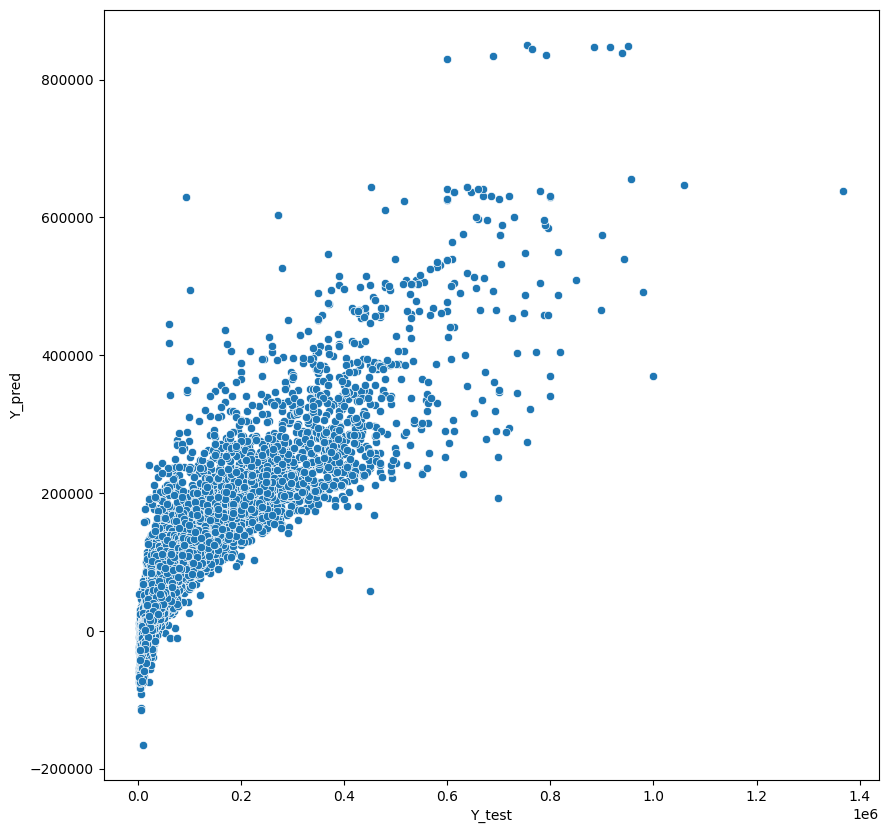

In [27]:
models = []
models_200_000 = []

from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, Y_train)

Y_pred = lin.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("Linear", r2_score(Y_test, Y_pred)))

MSE: 322266700.34172654
RMSE: 17951.78822128109
MAE: 12902.21049758365
R2: 0.8415352950498698



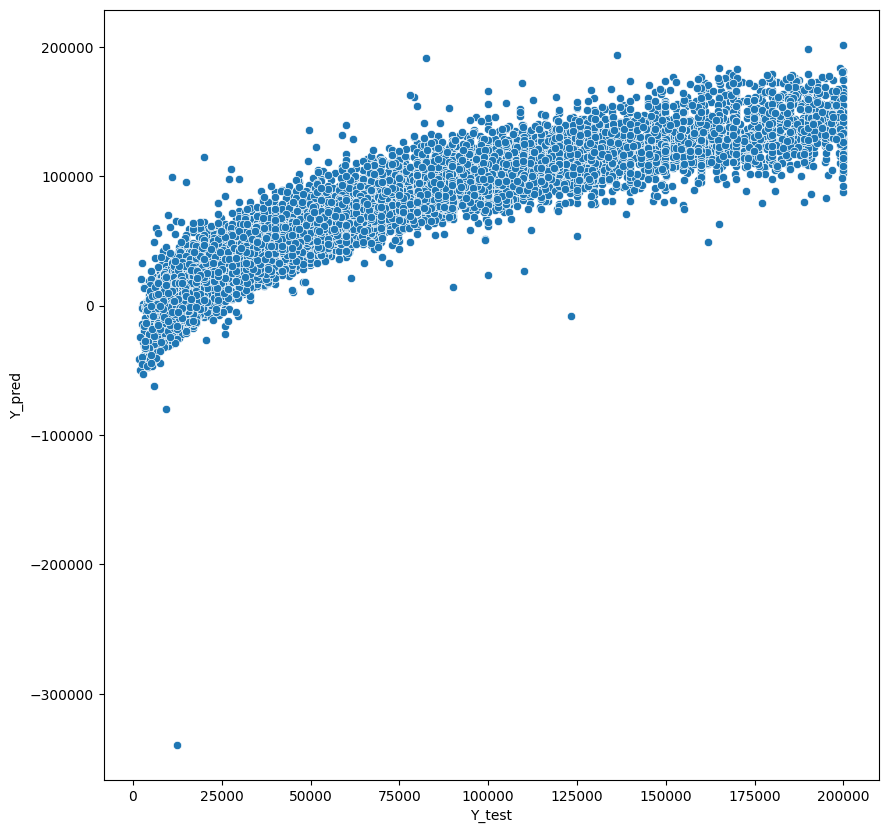

In [28]:
lin_200_000 = LinearRegression()
lin_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = lin_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("Linear", r2_score(Y_test_200_000, Y_pred_200_000)))

### Decision Tree


MSE: 672900034.2605718
RMSE: 25940.31677255642
MAE: 11102.155068901551
R2: 0.917336755319575



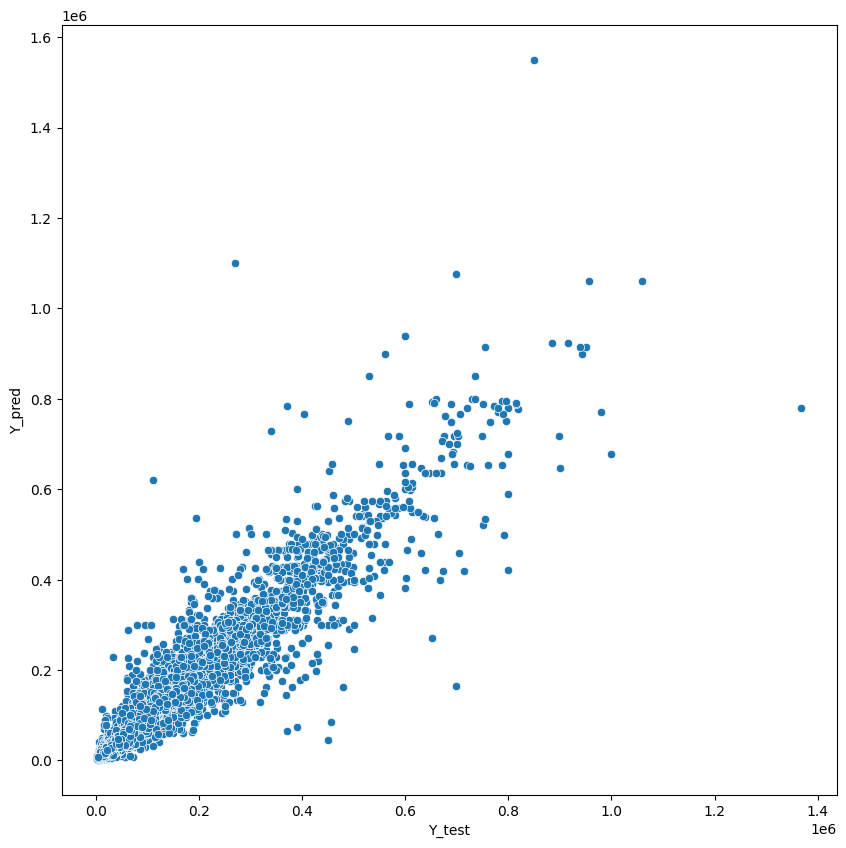

In [29]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor() #Стандарт очень удачно отработал, не меняем :)
dtr.fit(X_train, Y_train)

Y_pred = dtr.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("DTR", r2_score(Y_test, Y_pred)))

MSE: 197811139.27484262
RMSE: 14064.534804779098
MAE: 8021.766965886593
R2: 0.9027324765860135



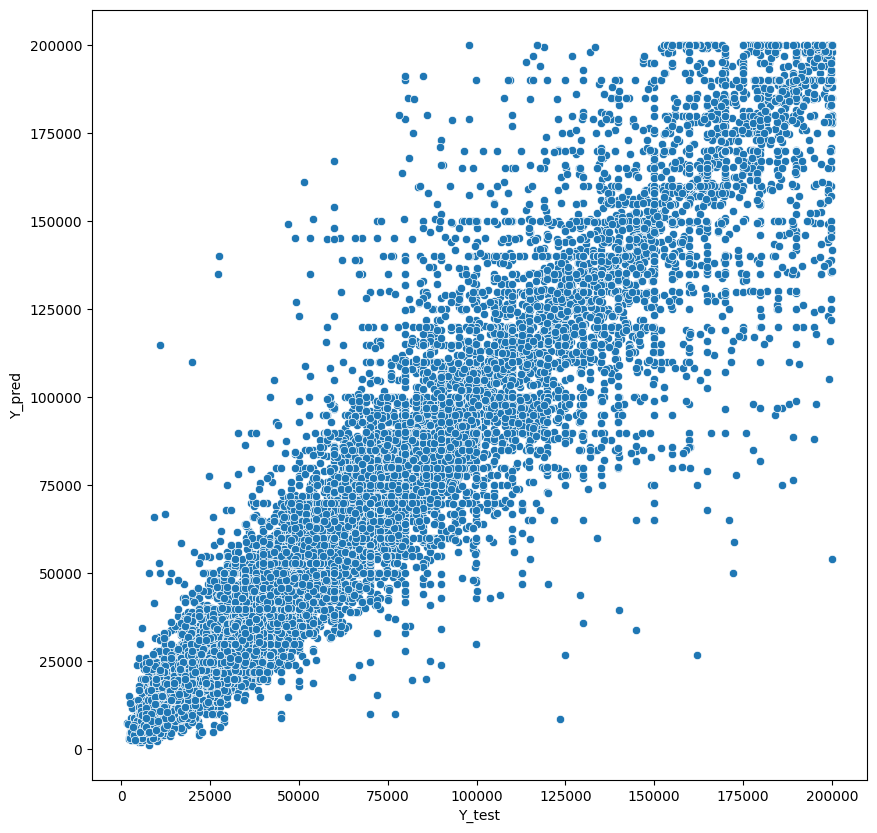

In [30]:
dtr_200_000 = DecisionTreeRegressor()
dtr_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = dtr_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("DTR", r2_score(Y_test_200_000, Y_pred_200_000)))

### Lasso

MSE: 1610961268.0637558
RMSE: 40136.78198440622
MAE: 24314.6608424827
R2: 0.8020994520843274



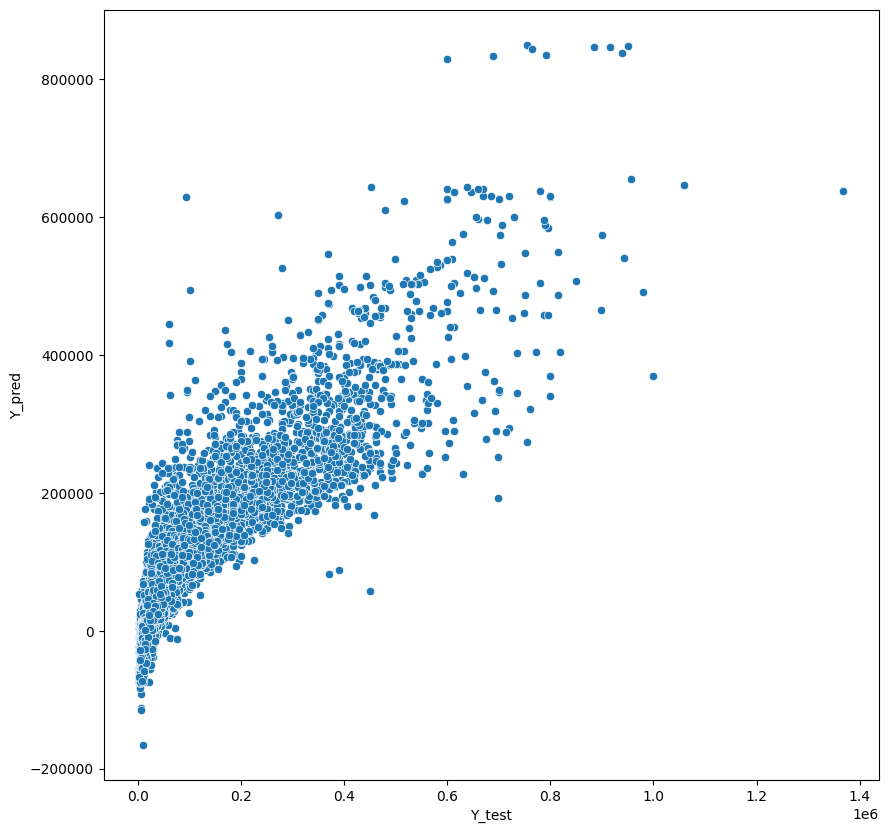

In [31]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

Y_pred = lasso.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("Lasso", r2_score(Y_test, Y_pred)))

MSE: 322199576.747727
RMSE: 17949.91857217539
MAE: 12900.093159757787
R2: 0.8415683010058281



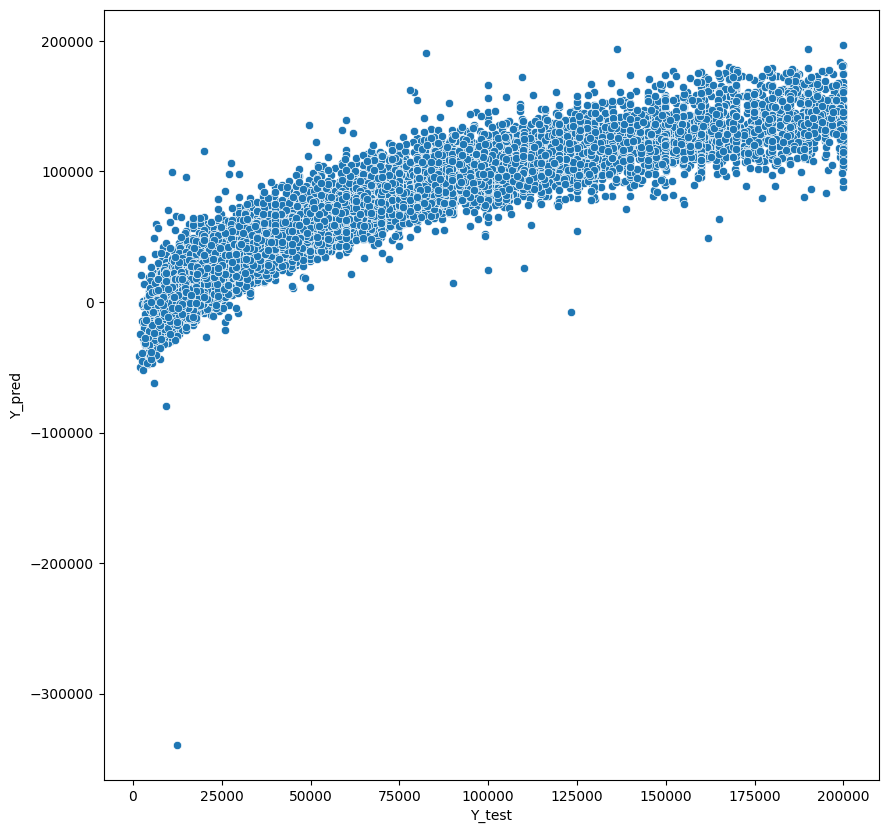

In [32]:
lasso_200_000 = Lasso(alpha=0.1)
lasso_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = lasso_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("Lasso", r2_score(Y_test_200_000, Y_pred_200_000)))

### Ridge

MSE: 1611029477.735373
RMSE: 40137.63169066373
MAE: 24319.43512180286
R2: 0.8020910727820725



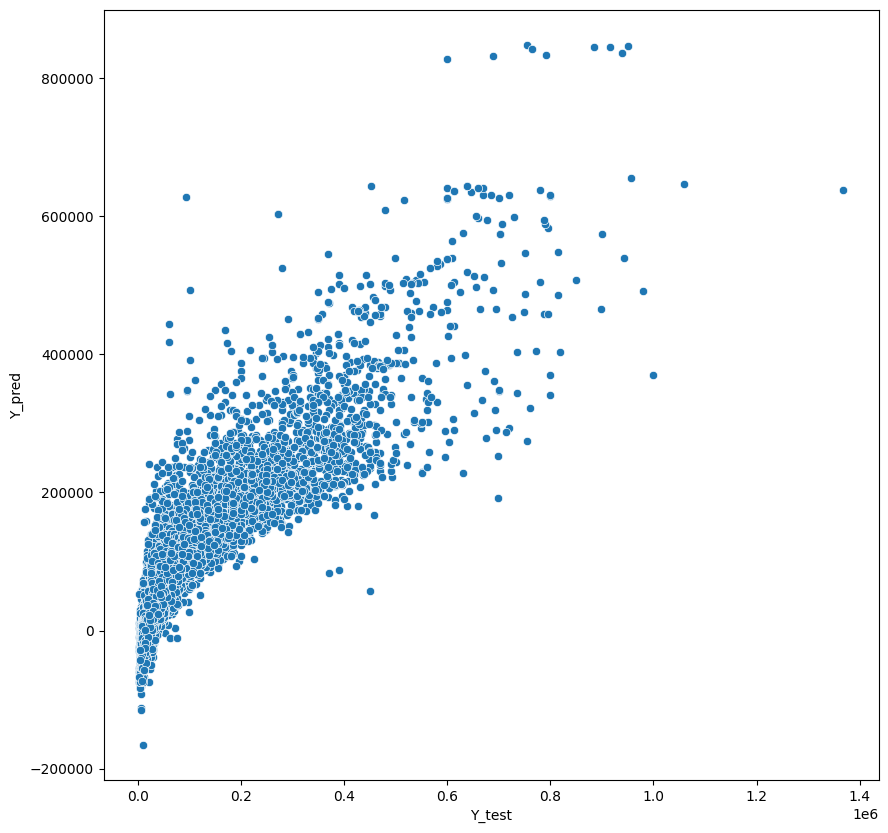

In [33]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, Y_train)

Y_pred = ridge.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("Ridge", r2_score(Y_test, Y_pred)))

MSE: 322208949.49669755
RMSE: 17950.179650819588
MAE: 12901.464958245962
R2: 0.8415636922457589



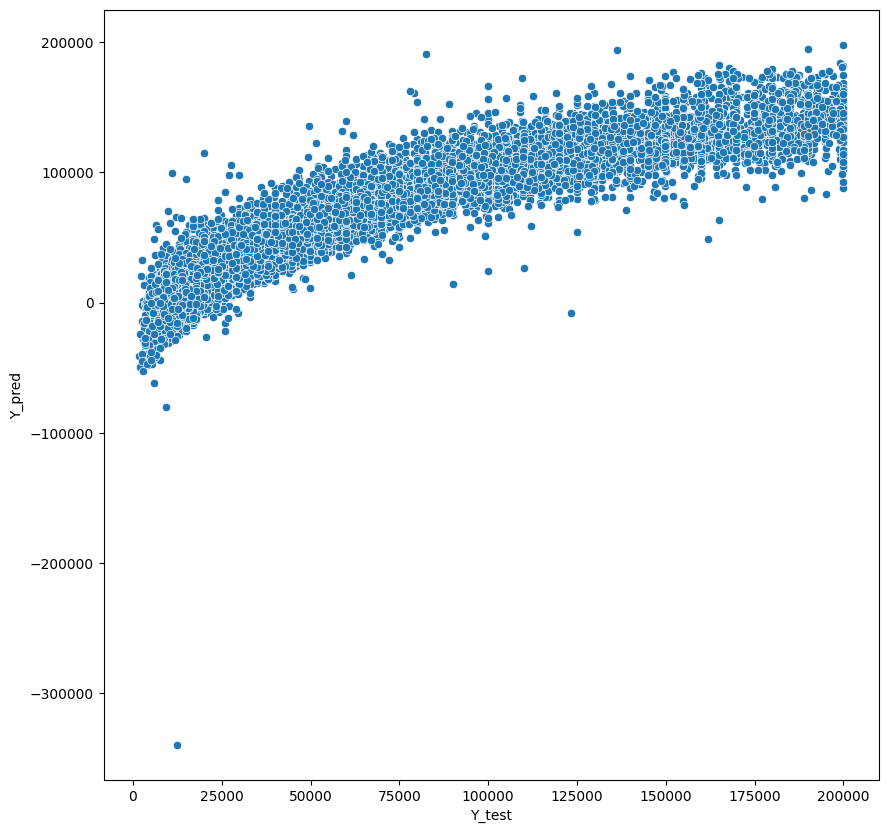

In [34]:
ridge_200_000 = Ridge(alpha=0.1)
ridge_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = ridge_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("Ridge", r2_score(Y_test_200_000, Y_pred_200_000)))

### XGBoost

MSE: 408451762.370037
RMSE: 20210.189567889684
MAE: 9166.680421278492
R2: 0.9498232333870404



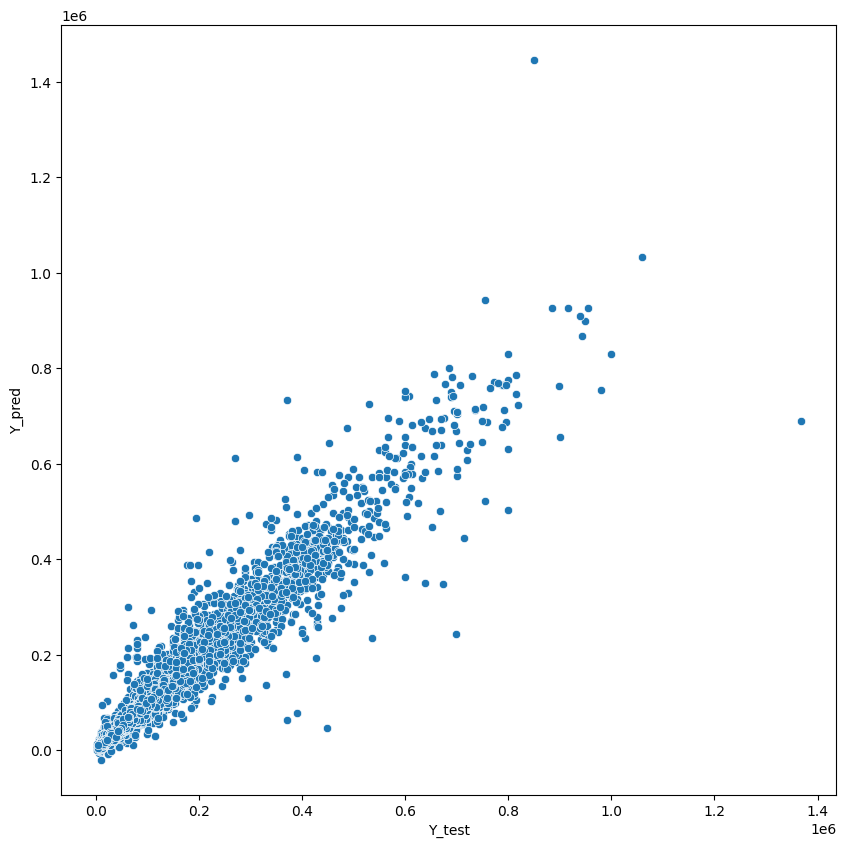

In [35]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=847)
xgb.fit(X_train, Y_train)

Y_pred = xgb.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("XGBoost", r2_score(Y_test, Y_pred)))

MSE: 116242468.6969996
RMSE: 10781.580064953356
MAE: 6511.711260567856
R2: 0.9428413531860035



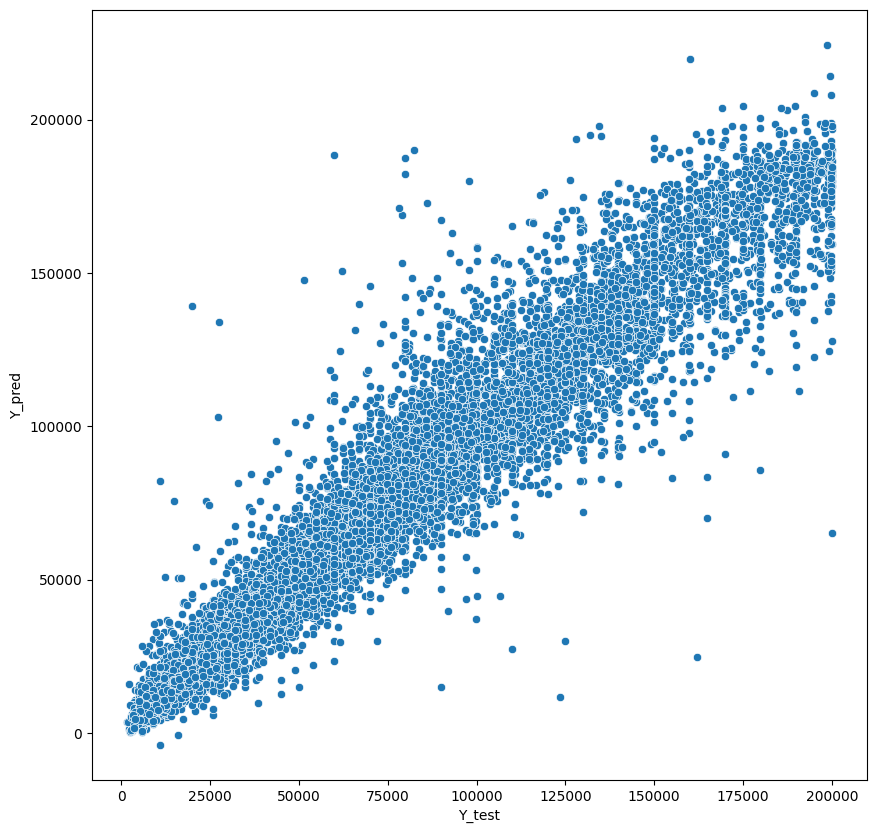

In [36]:
xgb_200_000 = XGBRegressor(n_estimators=847)
xgb_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = xgb_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("XGBoost", r2_score(Y_test_200_000, Y_pred_200_000)))

### ElasticNet

MSE: 3014758848.850821
RMSE: 54906.81969346632
MAE: 32845.52707897134
R2: 0.6296481859316883



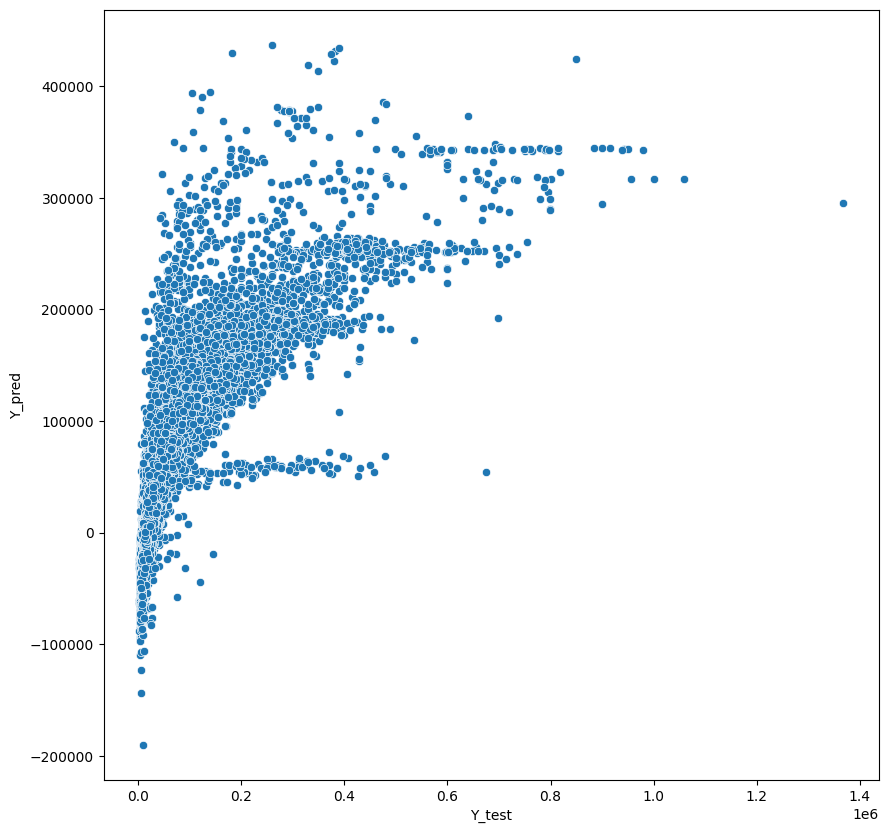

In [37]:
from sklearn.linear_model import ElasticNet

a = 0.8
b = 0.2
elastic = ElasticNet(alpha=a+b, l1_ratio=a/(a+b))
elastic.fit(X_train,Y_train)
Y_pred = elastic.predict(X_test)
print(show_error(Y_test, Y_pred))

models.append(("ElasticNet", r2_score(Y_test, Y_pred)))

MSE: 560548687.6366781
RMSE: 23675.909436316866
MAE: 16967.684426825395
R2: 0.7243674810263117



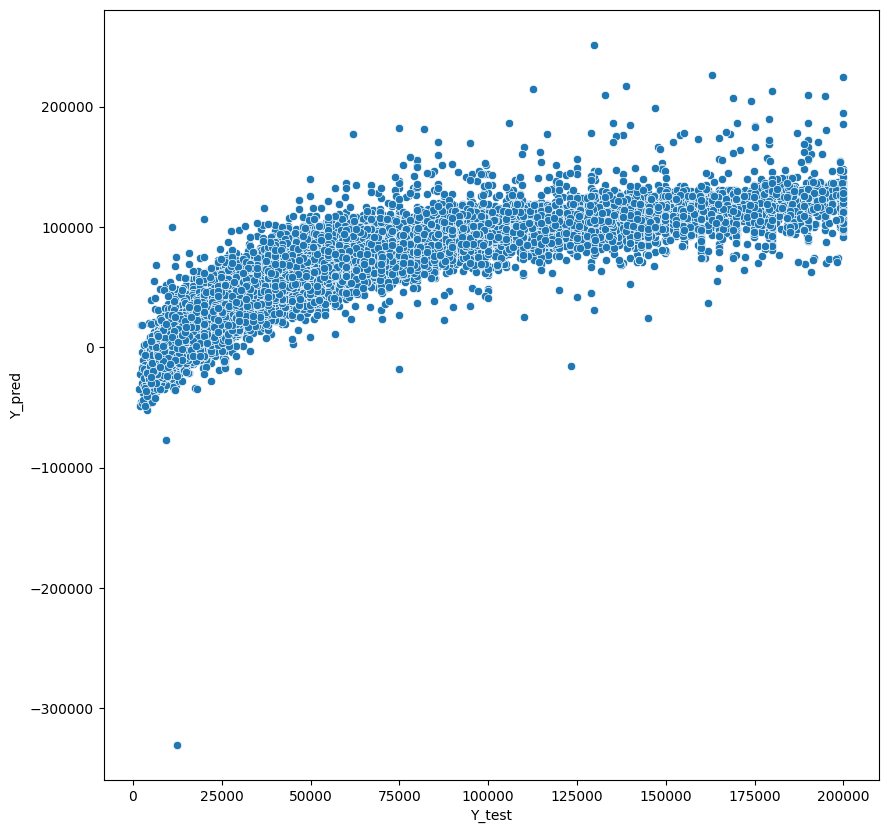

In [38]:
elastic_200_000 = ElasticNet(alpha=a+b, l1_ratio=a/(a+b))
elastic_200_000.fit(X_train_200_000, Y_train_200_000)

Y_pred_200_000 = elastic_200_000.predict(X_test_200_000)
print(show_error(Y_test_200_000, Y_pred_200_000))

models_200_000.append(("ElasticNet", r2_score(Y_test_200_000, Y_pred_200_000)))

# Итоги

Посмотрим на удачность предсказываний для моделей

Linear: 0.8
DTR: 0.92
Lasso: 0.8
Ridge: 0.8
XGBoost: 0.95
ElasticNet: 0.63


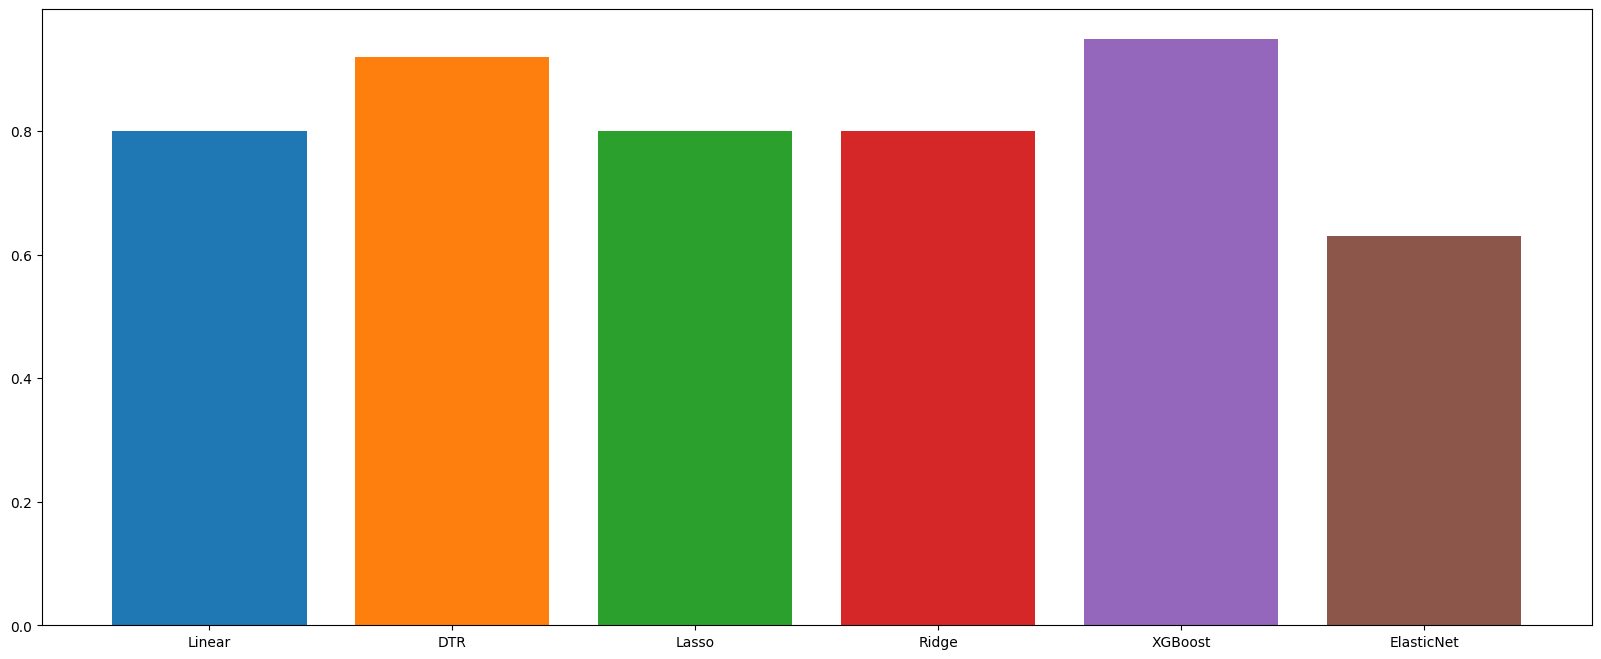

In [45]:
for model, r2 in models:
    r2_round = round(r2, 2)
    
    print(f"{model}: {r2_round}")
    plt.rcParams["figure.figsize"] = (20,8)
    plt.bar(model, r2_round)

Linear: 0.84
DTR: 0.9
Lasso: 0.84
Ridge: 0.84
XGBoost: 0.94
ElasticNet: 0.72


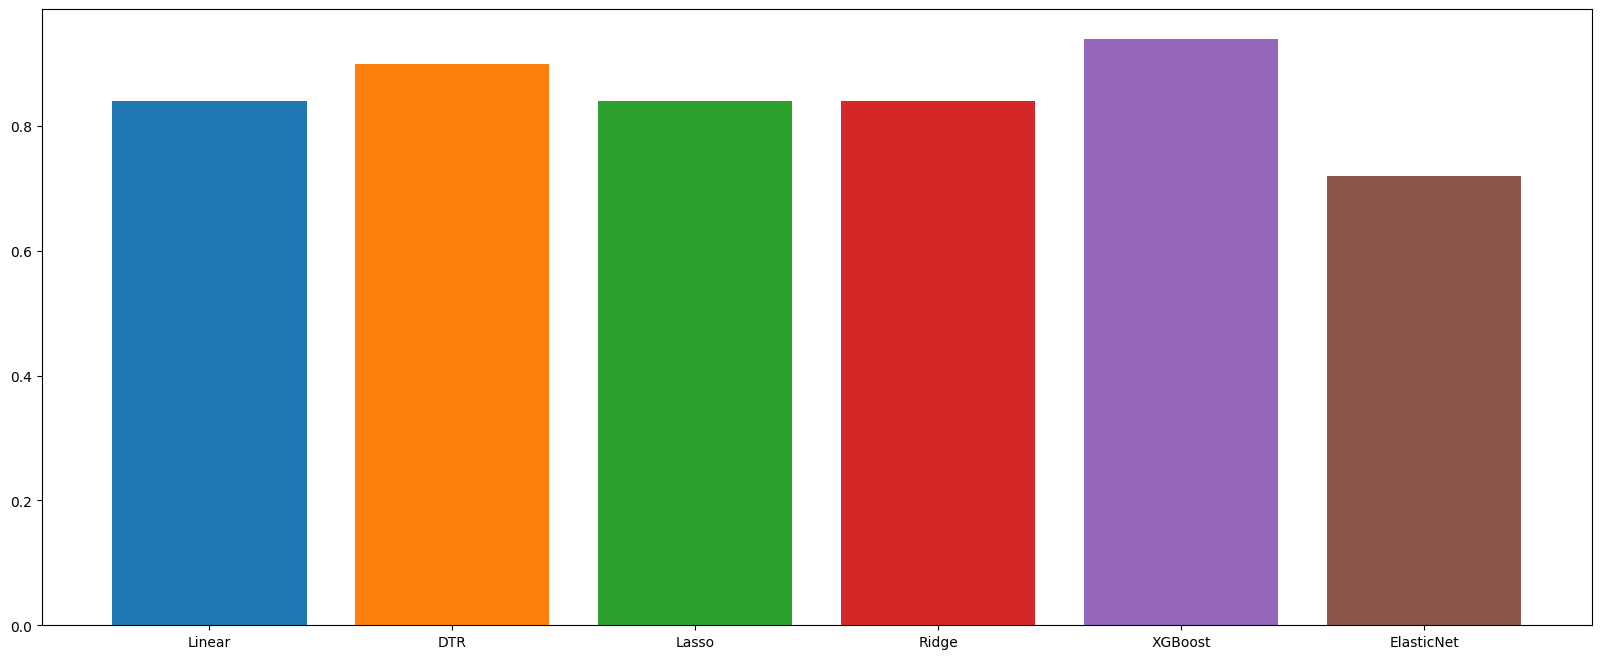

In [46]:
for model, r2 in models_200_000:
    r2_round = round(r2, 2)
    
    print(f"{model}: {r2_round}")
    plt.rcParams["figure.figsize"] = (20,8)
    plt.bar(model, r2_round)